Enes Pircek   488123

Original dataset link:
https://drive.google.com/file/d/1LfnSfPWtuTBooGU7IiNYseY4d9KuXzSe/view?usp=sharing
(Access: Anyone with the link can view/download)


In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

file_name = "appearances.csv" 

df = pd.read_csv(file_name)

print(f"Total rows: {len(df)}")
df.head()

Total rows: 1706806


,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,ELQ,0,0,0,0,45
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,ELQ,0,0,0,0,90
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,ELQ,0,0,0,1,90


Data inspection is crucial to understand the structure of the dataset, identify data types, and detect missing values before performing any analysis or modeling.

In [2]:
# Data Inspection

# Display the exact names of all columns
print("Column Names")
print(df.columns)

#  memory usage, data types, and non-null counts
print("\n Dataframe Summary ")
df.info()

# Calculate the total number of missing (NaN) values for each column
print("\n Missing Values Count ")
print(df.isnull().sum())

# Show statistical distribution (mean, min, max, etc.) for numerical columns
print("\n Descriptive Statistics ")
print(df.describe())

Column Names
Index(['appearance_id', 'game_id', 'player_id', 'player_club_id',
       'player_current_club_id', 'date', 'player_name', 'competition_id',
       'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played'],
      dtype='object')

 Dataframe Summary 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706806 entries, 0 to 1706805
Data columns (total 13 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   appearance_id           object
 1   game_id                 int64 
 2   player_id               int64 
 3   player_club_id          int64 
 4   player_current_club_id  int64 
 5   date                    object
 6   player_name             object
 7   competition_id          object
 8   yellow_cards            int64 
 9   red_cards               int64 
 10  goals                   int64 
 11  assists                 int64 
 12  minutes_played          int64 
dtypes: int64(9), object(4)
memory usage: 169.3+ MB

 Missing Values Count 


## Data Cleaning
In this step, we perform essential cleaning operations to ensure data integrity for further analysis:

Handling Missing Values: Removing rows where player_name is null.

Filtering Invalid Data: Removing records with player_current_club_id of -1 to exclude players without a valid club association.

Format Standardization: Converting the date column to a proper datetime object.

Index Refactoring: Resetting the index to maintain a clean and continuous sequence.

In [3]:
# Remove rows where 'player_name' is missing
df.dropna(subset=['player_name'], inplace=True)

# Remove rows where 'player_current_club_id' is -1
# We are filtering out players without a valid current club association
df = df[df['player_current_club_id'] != -1]

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Reset index to maintain a clean sequence after filtering
df.reset_index(drop=True, inplace=True)

# Verification
print("Cleaning process completed.")
print(f"Final row count after filtering: {len(df)}")

Cleaning process completed.
Final row count after filtering: 1706800


## Competition Analysis and Categorization Strategy

To make our analysis more meaningful and structured, we need to categorize the vast amount of data (1.7M rows) into logical groups. Our strategy involves two main dimensions:

1) Temporal Categorization (Timeline): We will analyze the data in two distinct periods: Pre-Pandemic (2012-2019) and Post-Pandemic (2020-2025) to observe potential shifts in performance metrics and player rotations.

2) Tier-Based Categorization: Not all competitions share the same level of intensity. We plan to group competitions by their "Difficulty Tier" (e.g., Top 5 European Leagues, Continental Trophies, and Domestic Cups).

Objective of this step: We are extracting the unique list of competition_id values to identify which codes correspond to which leagues. This will allow us to create a mapping for our SQL database and perform "Tier-specific" performance analysis.

In [4]:
# Retrieve all unique competition IDs from the 'competition_id' column
unique_competitions = df['competition_id'].unique()

# Output the total number of unique competitions found in the dataset
print(f"Total Number of Competitions: {len(unique_competitions)}")

# Iterate through and print the sorted list of competition IDs for classification
print(" Competition List: ")
for comp in sorted(unique_competitions):
    print(comp)

Total Number of Competitions: 43
 Competition List: 
BE1
BESC
CDR
CGB
CIT
CL
CLQ
DFB
DFL
DK1
DKP
ECLQ
EL
ELQ
ES1
FAC
FR1
FRCH
GB1
GBCS
GR1
GRP
IT1
KLUB
L1
NL1
NLP
NLSC
PO1
POCP
POSU
RU1
RUP
RUSS
SC1
SCI
SFA
SUC
TR1
UKR1
UKRP
UKRS
USC


In [5]:
# Defining the Temporal Split (Pre-Pandemic vs Post-Pandemic)
# We use the 'date' column to create a new 'period' column
df['date'] = pd.to_datetime(df['date'])
df['period'] = df['date'].dt.year.apply(lambda x: 'Pre-Pandemic' if x <= 2019 else 'Post-Pandemic')

# Defining Competition Tiers
# We create a mapping dictionary for each competition category
tier_mapping = {
    # Elite: Top 5 Leagues + CL/CLQ + USC
    'GB1': 'Elite', 'ES1': 'Elite', 'IT1': 'Elite', 'L1': 'Elite', 'FR1': 'Elite',
    'CL': 'Elite', 'CLQ': 'Elite', 'USC': 'Elite',
    
    # Competitive: Secondary Leagues + EL/ELQ + ECLQ
    'TR1': 'Competitive', 'NL1': 'Competitive', 'PO1': 'Competitive', 'BE1': 'Competitive',
    'RU1': 'Competitive', 'UKR1': 'Competitive', 'GR1': 'Competitive',
    'EL': 'Competitive', 'ELQ': 'Competitive', 'ECLQ': 'Competitive'
}

# 3. Applying the mapping and categorizing the rest as 'Cups & Others'
df['tier'] = df['competition_id'].map(tier_mapping).fillna('Cups & Others')

# Displaying the first few rows to verify the new columns
print("New columns 'period' and 'tier' have been successfully added.")
print(df[['date', 'period', 'competition_id', 'tier']].head())

New columns 'period' and 'tier' have been successfully added.
        date        period competition_id         tier
0 2012-07-03  Pre-Pandemic            CLQ        Elite
1 2012-07-05  Pre-Pandemic            ELQ  Competitive
2 2012-07-05  Pre-Pandemic            ELQ  Competitive
3 2012-07-05  Pre-Pandemic            ELQ  Competitive
4 2012-07-05  Pre-Pandemic            ELQ  Competitive


## Calculating Core Performance Metrics
In this step, we calculate our 4 key performance indicators (KPIs) to prepare the data for SQL analysis. This involves aggregating player statistics and applying custom formulas for efficiency and discipline.

- Score Contribution: goals + assists

- Efficiency: (goals + assists) / minutes_played

- Discipline Score: (yellow_cards * 1) + (red_cards * 3)

- Continuity: Total minutes

In [6]:
# Grouping by player and tier to see performance at different levels
# We also include 'period' to keep the pandemic split
player_stats = df.groupby(['player_id', 'player_name', 'tier', 'period']).agg({
    'goals': 'sum',
    'assists': 'sum',
    'yellow_cards': 'sum',
    'red_cards': 'sum',
    'minutes_played': 'sum'
}).reset_index()

# 1. Total Contribution (Goal + Assist)
player_stats['total_contribution'] = player_stats['goals'] + player_stats['assists']

# 2. Efficiency (Contribution per Minute)
player_stats['efficiency'] = player_stats['total_contribution'] / (player_stats['minutes_played'] + 0.0001)

# 3. Discipline Score (Weighted: Red=3, Yellow=1)
player_stats['discipline_score'] = (player_stats['yellow_cards'] * 1) + (player_stats['red_cards'] * 3)

# 4. Continuity (Total Minutes Played)
print("Player performance metrics (4 Core KPIs) have been calculated.")
player_stats.head(20)

Player performance metrics (4 Core KPIs) have been calculated.


,player_id,player_name,tier,period,goals,assists,yellow_cards,red_cards,minutes_played,total_contribution,efficiency,discipline_score
0,10,Miroslav Klose,Competitive,Pre-Pandemic,3,0,2,0,516,3,0.005814,2
1,10,Miroslav Klose,Cups & Others,Pre-Pandemic,3,2,2,0,848,5,0.005896,2
2,10,Miroslav Klose,Elite,Pre-Pandemic,42,23,15,0,7444,65,0.008732,15
3,26,Roman Weidenfeller,Competitive,Pre-Pandemic,0,0,1,0,1170,0,0.000000,1
4,26,Roman Weidenfeller,Cups & Others,Pre-Pandemic,0,0,0,0,1050,0,0.000000,0
5,26,Roman Weidenfeller,Elite,Pre-Pandemic,0,0,3,2,11288,0,0.000000,9
6,65,Dimitar Berbatov,Competitive,Pre-Pandemic,4,0,1,1,1000,4,0.004000,4
7,65,Dimitar Berbatov,Cups & Others,Pre-Pandemic,1,0,1,0,330,1,0.003030,1
8,65,Dimitar Berbatov,Elite,Pre-Pandemic,33,13,9,0,7458,46,0.006168,9
9,77,Lúcio,Cups & Others,Pre-Pandemic,0,0,0,0,120,0,0.000000,0


## SQL Database Creation and Data Transfer

In this step, we convert the processed player_stats DataFrame into an SQLite database. This allows us to store the data in a relational structure and perform in-depth analysis using SQL queries.

In [7]:
import sqlite3

# Creating a SQL database connection (creates a file named football_data.db)
conn = sqlite3.connect('football_data.db')

# Transferring player_stats DataFrame to SQL table
# Table name: player_performances
player_stats.to_sql('player_performances', conn, if_exists='replace', index=False)

print("Data has been successfully transferred to the SQL database!")
print("Table Name: 'player_performances'")

Data has been successfully transferred to the SQL database!
Table Name: 'player_performances'


## Top 10 Players by Score Contribution per Tier (Post-Pandemic)
This step focuses on our Score Contribution KPI (Goals + Assists). While efficiency measures productivity per minute, this metric highlights the absolute impact of players on the scoreboard. We rank the top 10 contributors for each tier to see who dominated the Post-Pandemic era in terms of total output.

In [8]:
query_contribution_post = """
SELECT * FROM (
    SELECT player_name, tier, period, total_contribution, goals, assists
    FROM player_performances
    WHERE tier = 'Elite' AND period = 'Post-Pandemic'
    ORDER BY total_contribution DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, total_contribution, goals, assists
    FROM player_performances
    WHERE tier = 'Competitive' AND period = 'Post-Pandemic'
    ORDER BY total_contribution DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, total_contribution, goals, assists
    FROM player_performances
    WHERE (tier = 'Cups & Others' OR tier = 'Other') AND period = 'Post-Pandemic'
    ORDER BY total_contribution DESC LIMIT 10
)
"""

top_contrib_post = pd.read_sql(query_contribution_post, conn)
top_contrib_post['rank'] = top_contrib_post.groupby('tier')['total_contribution'].rank(ascending=False, method='first').astype(int)
top_contrib_post = top_contrib_post[['rank', 'player_name', 'tier', 'total_contribution', 'goals', 'assists']]

top_contrib_post

,rank,player_name,tier,total_contribution,goals,assists
0,1,Robert Lewandowski,Elite,241,200,41
1,2,Kylian Mbappé,Elite,237,177,60
2,3,Erling Haaland,Elite,225,187,38
3,4,Mohamed Salah,Elite,217,144,73
4,5,Harry Kane,Elite,206,155,51
5,6,Lautaro Martínez,Elite,152,114,38
6,7,Lionel Messi,Elite,144,79,65
7,8,Vinicius Junior,Elite,139,79,60
8,9,Thomas Müller,Elite,136,51,85
9,10,Kevin De Bruyne,Elite,130,51,79


## Top 10 Players by Score Contribution per Tier (Pre-Pandemic)
To establish a historical baseline for absolute player output, we now analyze the Score Contribution KPI (Goals + Assists) for the Pre-Pandemic era. This allows us to identify which players were the primary offensive anchors in their respective tiers before the pandemic, providing the necessary data for a direct "Pre vs Post" output comparison.

In [9]:
# SQL query to fetch top 10 contributors for the Pre-Pandemic era
query_contribution_pre = """
SELECT * FROM (
    SELECT player_name, tier, period, total_contribution, goals, assists
    FROM player_performances
    WHERE tier = 'Elite' AND period = 'Pre-Pandemic'
    ORDER BY total_contribution DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, total_contribution, goals, assists
    FROM player_performances
    WHERE tier = 'Competitive' AND period = 'Pre-Pandemic'
    ORDER BY total_contribution DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, total_contribution, goals, assists
    FROM player_performances
    WHERE (tier = 'Cups & Others' OR tier = 'Other') AND period = 'Pre-Pandemic'
    ORDER BY total_contribution DESC LIMIT 10
)
"""

top_contrib_pre = pd.read_sql(query_contribution_pre, conn)

# Ranking the historical contributors (1-10) for each tier group
top_contrib_pre['rank'] = top_contrib_pre.groupby('tier')['total_contribution'].rank(ascending=False, method='first').astype(int)

# Organizing columns for consistent display
top_contrib_pre = top_contrib_pre[['rank', 'player_name', 'tier', 'total_contribution', 'goals', 'assists']]

top_contrib_pre

,rank,player_name,tier,total_contribution,goals,assists
0,1,Lionel Messi,Elite,456,328,128
1,2,Cristiano Ronaldo,Elite,418,322,96
2,3,Luis Suárez,Elite,341,216,125
3,4,Robert Lewandowski,Elite,315,253,62
4,5,Karim Benzema,Elite,243,155,88
5,6,Neymar,Elite,243,143,100
6,7,Sergio Agüero,Elite,237,187,50
7,8,Edinson Cavani,Elite,230,195,35
8,9,Pierre-Emerick Aubameyang,Elite,224,177,47
9,10,Zlatan Ibrahimović,Elite,211,150,61


## Top 10 Efficient Players per Tier (Post-Pandemic)
In this analysis, we identify the top 10 players with the highest Efficiency scores within each difficulty tier specifically for the Post-Pandemic period. Efficiency is calculated using the following formula:$$\text{Efficiency} = \frac{\text{Goals} + \text{Assists}}{\text{Minutes Played}}$$By filtering for players with more than 500 minutes played, we ensure that our performance rankings are based on consistent and reliable data, avoiding "noise" from players with very low game time.

In [10]:
# SQL query to fetch top 10 players for each tier with a 500-minute threshold
query_efficiency_post = """
SELECT * FROM (
    SELECT player_name, tier, period, efficiency, total_contribution, minutes_played
    FROM player_performances
    WHERE tier = 'Elite' AND period = 'Post-Pandemic' AND minutes_played > 500
    ORDER BY efficiency DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, efficiency, total_contribution, minutes_played
    FROM player_performances
    WHERE tier = 'Competitive' AND period = 'Post-Pandemic' AND minutes_played > 500
    ORDER BY efficiency DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, efficiency, total_contribution, minutes_played
    FROM player_performances
    WHERE (tier = 'Cups & Others' OR tier = 'Other') AND period = 'Post-Pandemic' AND minutes_played > 500
    ORDER BY efficiency DESC LIMIT 10
)
"""

top_efficient_post = pd.read_sql(query_efficiency_post, conn)

# Create a rank column (1 to 10) for each tier group to improve readability
top_efficient_post['rank'] = top_efficient_post.groupby('tier')['efficiency'].rank(ascending=False, method='first').astype(int)

# Reordering columns to place 'rank' at the beginning
top_efficient_post = top_efficient_post[['rank', 'player_name', 'tier', 'efficiency', 'total_contribution', 'minutes_played']]

top_efficient_post

,rank,player_name,tier,efficiency,total_contribution,minutes_played
0,1,Erling Haaland,Elite,0.013406,225,16783
1,2,Luis Muriel,Elite,0.013250,72,5434
2,3,Robert Lewandowski,Elite,0.012956,241,18601
3,4,Kylian Mbappé,Elite,0.012954,237,18296
4,5,Victor Boniface,Elite,0.012884,39,3027
5,6,Lionel Messi,Elite,0.012129,144,11872
6,7,Sergio Agüero,Elite,0.011981,15,1252
7,8,Eran Zahavi,Elite,0.011516,6,521
8,9,Karim Benzema,Elite,0.011493,97,8440
9,10,Neymar,Elite,0.011361,85,7482


## Top 10 Efficient Players per Tier (Pre-Pandemic)
Following the same logic, we extract the top performers from the Pre-Pandemic era. This historical data is crucial for our upcoming visualization phase, where we will analyze how player efficiency has evolved across different league tiers before and after the global break.

In [11]:
# Fetching historical efficiency data for comparative analysis
query_efficiency_pre = """
SELECT * FROM (
    SELECT player_name, tier, period, efficiency, total_contribution, minutes_played
    FROM player_performances
    WHERE tier = 'Elite' AND period = 'Pre-Pandemic' AND minutes_played > 500
    ORDER BY efficiency DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, efficiency, total_contribution, minutes_played
    FROM player_performances
    WHERE tier = 'Competitive' AND period = 'Pre-Pandemic' AND minutes_played > 500
    ORDER BY efficiency DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, efficiency, total_contribution, minutes_played
    FROM player_performances
    WHERE (tier = 'Cups & Others' OR tier = 'Other') AND period = 'Pre-Pandemic' AND minutes_played > 500
    ORDER BY efficiency DESC LIMIT 10
)
"""

top_efficient_pre = pd.read_sql(query_efficiency_pre, conn)

# Apply ranking to organize historical data by tier
top_efficient_pre['rank'] = top_efficient_pre.groupby('tier')['efficiency'].rank(ascending=False, method='first').astype(int)

# Organize columns for final display
top_efficient_pre = top_efficient_pre[['rank', 'player_name', 'tier', 'efficiency', 'total_contribution', 'minutes_played']]

top_efficient_pre

,rank,player_name,tier,efficiency,total_contribution,minutes_played
0,1,Lionel Messi,Elite,0.016878,456,27018
1,2,Aurélien Joachim,Elite,0.015748,8,508
2,3,Cristiano Ronaldo,Elite,0.014776,418,28290
3,4,Kylian Mbappé,Elite,0.014574,136,9332
4,5,Zlatan Ibrahimović,Elite,0.013462,211,15674
5,6,Luis Suárez,Elite,0.013233,341,25769
6,7,Neymar,Elite,0.012903,243,18833
7,8,Sergio Agüero,Elite,0.011842,237,20014
8,9,Robert Lewandowski,Elite,0.011835,315,26617
9,10,Jadon Sancho,Elite,0.011466,60,5233


## Top 10 Aggressive Players per Tier (Post-Pandemic)
In this step, we analyze our Discipline Score KPI for the Post-Pandemic period. By identifying the players with the highest scores (Yellow Cards * 1 + Red Cards * 3) in each tier, we can pinpoint the most aggressive performers. We apply a ranking system within each category to clearly distinguish the leaders in discipline points.

In [12]:
# SQL query to identify players with the highest discipline scores
query_discipline_post = """
SELECT * FROM (
    SELECT player_name, tier, period, yellow_cards, red_cards, discipline_score
    FROM player_performances
    WHERE tier = 'Elite' AND period = 'Post-Pandemic'
    ORDER BY discipline_score DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, yellow_cards, red_cards, discipline_score
    FROM player_performances
    WHERE tier = 'Competitive' AND period = 'Post-Pandemic'
    ORDER BY discipline_score DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, yellow_cards, red_cards, discipline_score
    FROM player_performances
    WHERE (tier = 'Cups & Others' OR tier = 'Other') AND period = 'Post-Pandemic'
    ORDER BY discipline_score DESC LIMIT 10
)
"""

top_discipline_post = pd.read_sql(query_discipline_post, conn)

# Ranking the most aggressive players (1-10) for each tier
top_discipline_post['rank'] = top_discipline_post.groupby('tier')['discipline_score'].rank(ascending=False, method='first').astype(int)

# Organizing columns for the final dataframe
top_discipline_post = top_discipline_post[['rank', 'player_name', 'tier', 'discipline_score', 'yellow_cards', 'red_cards']]

top_discipline_post

,rank,player_name,tier,discipline_score,yellow_cards,red_cards
0,1,Djené,Elite,65,56,3
1,2,Casemiro,Elite,60,54,2
2,3,Benjamin André,Elite,60,60,0
3,4,Stefan Savic,Elite,60,51,3
4,5,Theo Hernández,Elite,60,51,3
5,6,Dominik Kohr,Elite,56,53,1
6,7,Gianluca Mancini,Elite,56,56,0
7,8,Cristian Romero,Elite,54,51,1
8,9,Facundo Medina,Elite,54,54,0
9,10,Téji Savanier,Elite,53,32,7


## Top 10 Aggressive Players per Tier (Pre-Pandemic)
To complete our comparative dataset, we now extract the most aggressive players from the Pre-Pandemic era. This allow us to compare if the level of aggression or the number of cards has significantly changed across different league tiers before and after the global break.

In [13]:
# Fetching historical discipline data
query_discipline_pre = """
SELECT * FROM (
    SELECT player_name, tier, period, yellow_cards, red_cards, discipline_score
    FROM player_performances
    WHERE tier = 'Elite' AND period = 'Pre-Pandemic'
    ORDER BY discipline_score DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, yellow_cards, red_cards, discipline_score
    FROM player_performances
    WHERE tier = 'Competitive' AND period = 'Pre-Pandemic'
    ORDER BY discipline_score DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, yellow_cards, red_cards, discipline_score
    FROM player_performances
    WHERE (tier = 'Cups & Others' OR tier = 'Other') AND period = 'Pre-Pandemic'
    ORDER BY discipline_score DESC LIMIT 10
)
"""

top_discipline_pre = pd.read_sql(query_discipline_pre, conn)

# Apply ranking to organize historical data by tier
top_discipline_pre['rank'] = top_discipline_pre.groupby('tier')['discipline_score'].rank(ascending=False, method='first').astype(int)

# Organize columns for final display
top_discipline_pre = top_discipline_pre[['rank', 'player_name', 'tier', 'discipline_score', 'yellow_cards', 'red_cards']]

top_discipline_pre

,rank,player_name,tier,discipline_score,yellow_cards,red_cards
0,1,Sergio Ramos,Elite,112,103,3
1,2,Víctor Sánchez,Elite,102,99,1
2,3,Dani Parejo,Elite,87,81,2
3,4,Rubén Pérez,Elite,87,84,1
4,5,Marco Verratti,Elite,85,85,0
5,6,Sergio Busquets,Elite,84,81,1
6,7,Daniel Carvajal,Elite,83,80,1
7,8,Álvaro González,Elite,83,74,3
8,9,Mario Balotelli,Elite,81,69,4
9,10,Granit Xhaka,Elite,79,70,3


## Top 10 Players by Continuity per Tier (Post-Pandemic)
In this step, we analyze the Continuity KPI specifically for the Post-Pandemic period. Continuity serves as a primary indicator of a player's reliability and their role as a "backbone" for the team. We rank the top 10 players in each difficulty tier based on their Total Minutes Played, highlighting those who have maintained the most consistent presence on the pitch in the modern era.

In [14]:
query_continuity_post = """
SELECT * FROM (
    SELECT player_name, tier, period, minutes_played
    FROM player_performances
    WHERE tier = 'Elite' AND period = 'Post-Pandemic'
    ORDER BY minutes_played DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, minutes_played
    FROM player_performances
    WHERE tier = 'Competitive' AND period = 'Post-Pandemic'
    ORDER BY minutes_played DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, minutes_played
    FROM player_performances
    WHERE (tier = 'Cups & Others' OR tier = 'Other') AND period = 'Post-Pandemic'
    ORDER BY minutes_played DESC LIMIT 10
)
"""

top_continuity_post = pd.read_sql(query_continuity_post, conn)

# Ranking by total minutes
top_continuity_post['rank'] = top_continuity_post.groupby('tier')['minutes_played'].rank(ascending=False, method='first').astype(int)

# Organizing final columns
top_continuity_post = top_continuity_post[['rank', 'player_name', 'tier', 'minutes_played']]

top_continuity_post

,rank,player_name,tier,minutes_played
0,1,Jan Oblak,Elite,21394
1,2,Ederson,Elite,20741
2,3,Mohamed Salah,Elite,19381
3,4,Alisson,Elite,18739
4,5,Giovanni Di Lorenzo,Elite,18715
5,6,Robert Lewandowski,Elite,18601
6,7,Thibaut Courtois,Elite,18333
7,8,Harry Kane,Elite,18299
8,9,Kylian Mbappé,Elite,18296
9,10,Joshua Kimmich,Elite,18241


## Top 10 Players by Continuity per Tier (Pre-Pandemic)
We perform the same continuity analysis for the Pre-Pandemic era to establish our historical baseline for player workload across all difficulty tiers.

In [15]:
query_continuity_pre = """
SELECT * FROM (
    SELECT player_name, tier, period, minutes_played
    FROM player_performances
    WHERE tier = 'Elite' AND period = 'Pre-Pandemic'
    ORDER BY minutes_played DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, minutes_played
    FROM player_performances
    WHERE tier = 'Competitive' AND period = 'Pre-Pandemic'
    ORDER BY minutes_played DESC LIMIT 10
)
UNION ALL
SELECT * FROM (
    SELECT player_name, tier, period, minutes_played
    FROM player_performances
    WHERE (tier = 'Cups & Others' OR tier = 'Other') AND period = 'Pre-Pandemic'
    ORDER BY minutes_played DESC LIMIT 10
)
"""

top_continuity_pre = pd.read_sql(query_continuity_pre, conn)

# Ranking historical continuity
top_continuity_pre['rank'] = top_continuity_pre.groupby('tier')['minutes_played'].rank(ascending=False, method='first').astype(int)

# Organizing final columns
top_continuity_pre = top_continuity_pre[['rank', 'player_name', 'tier', 'minutes_played']]

top_continuity_pre

,rank,player_name,tier,minutes_played
0,1,Cristiano Ronaldo,Elite,28290
1,2,David de Gea,Elite,27434
2,3,Lionel Messi,Elite,27018
3,4,Leonardo Bonucci,Elite,26751
4,5,Robert Lewandowski,Elite,26617
5,6,Luis Suárez,Elite,25769
6,7,Bernd Leno,Elite,25635
7,8,Samir Handanovic,Elite,25610
8,9,César Azpilicueta,Elite,25507
9,10,Sergio Busquets,Elite,25305


## Comparative Analysis of Player Performance Across Tiers and Pandemic Periods
In this section, we visualize the aggregated data stored in our SQL database to uncover trends across different league difficulty levels and temporal shifts. We analyze our 4 Core KPIs to understand the "Big Picture" of football evolution.

## Key Performance Indicators (KPIs):
Score Contribution: Average sum of goals and assists per player.

Efficiency: Average goal/assist production per minute played (quality of time on pitch).

Discipline Score: Weighted average of disciplinary actions (Yellow Cards = 1, Red Cards = 3).

Continuity: Average total minutes played, representing player workload and reliability.

## Analysis Dimensions:
League Tiers: Elite (Top 5 + CL), Competitive (Secondary Leagues), and Cups & Others.

Temporal Periods: Pre-Pandemic (2012-2019) vs. Post-Pandemic (2020-2025).

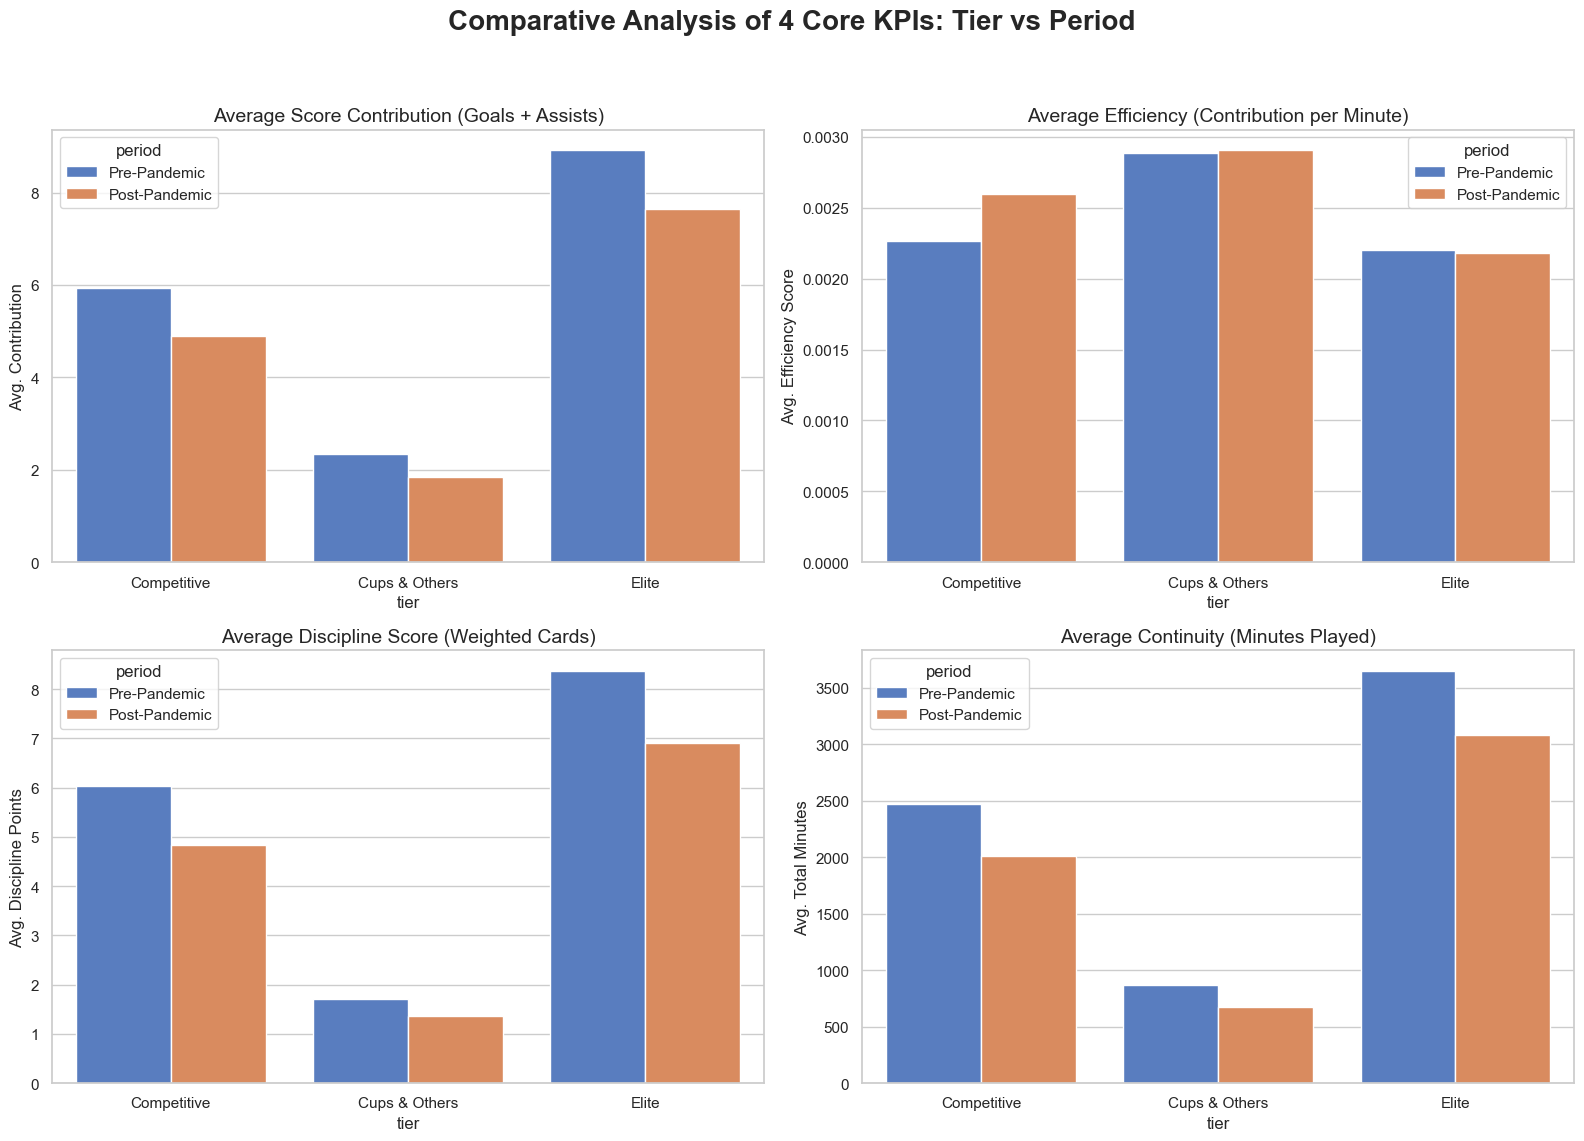

In [16]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Connect to the database and fetch the data
conn = sqlite3.connect('football_data.db')

# Aggregate data by Tier and Period for all 4 KPIs
query = """
SELECT 
    tier, 
    period,
    AVG(total_contribution) as avg_contribution,
    AVG(efficiency) as avg_efficiency,
    AVG(discipline_score) as avg_discipline,
    AVG(minutes_played) as avg_continuity
FROM player_performances
GROUP BY tier, period
ORDER BY tier, period DESC
"""

df_viz = pd.read_sql_query(query, conn)
conn.close()

# 2. Set the visual style for professional look (Seaborn)
sns.set_theme(style="whitegrid", palette="muted")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparative Analysis of 4 Core KPIs: Tier vs Period', fontsize=20, fontweight='bold')

# KPI 1: Score Contribution
sns.barplot(ax=axes[0, 0], data=df_viz, x='tier', y='avg_contribution', hue='period')
axes[0, 0].set_title('Average Score Contribution (Goals + Assists)', fontsize=14)
axes[0, 0].set_ylabel('Avg. Contribution')

# KPI 2: Efficiency
sns.barplot(ax=axes[0, 1], data=df_viz, x='tier', y='avg_efficiency', hue='period')
axes[0, 1].set_title('Average Efficiency (Contribution per Minute)', fontsize=14)
axes[0, 1].set_ylabel('Avg. Efficiency Score')

# KPI 3: Discipline Score
sns.barplot(ax=axes[1, 0], data=df_viz, x='tier', y='avg_discipline', hue='period')
axes[1, 0].set_title('Average Discipline Score (Weighted Cards)', fontsize=14)
axes[1, 0].set_ylabel('Avg. Discipline Points')

# KPI 4: Continuity
sns.barplot(ax=axes[1, 1], data=df_viz, x='tier', y='avg_continuity', hue='period')
axes[1, 1].set_title('Average Continuity (Minutes Played)', fontsize=14)
axes[1, 1].set_ylabel('Avg. Total Minutes')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])


plt.savefig('global_kpi_comparison.png', dpi=300)
plt.show()

## Key Findings and Insights
Based on the comparative visualization, we can draw the following conclusions regarding the evolution of player performance:

Global Workload Shift: There is a visible decrease in Continuity (Total Minutes) across all tiers in the Post-Pandemic era. This suggests that expanded rosters and the "5-substitute rule" have successfully distributed the physical load among more players.

The Efficiency Paradox: While total Score Contribution has slightly declined, Efficiency remains high, particularly in "Competitive" and "Cups & Others" tiers. This indicates that players are producing more "impact per minute," even if they spend less total time on the pitch.

Elite League Difficulty: The "Elite" tier shows the highest total output but lower relative efficiency compared to cup matches. This confirms that scoring in top-flight European football remains the most difficult challenge due to superior defensive organizations.

Behavioral Change: A significant drop in the Discipline Score is observed globally. The transition to the Post-Pandemic era (including the wider adoption of VAR and matches played behind closed doors initially) seems to have led to a more "disciplined" or less aggressive playing style.

### 📊 Efficiency Distribution Across Tiers (Box Plot)
To understand the overall quality and consistency of player performances, we analyze the distribution of the **Efficiency** KPI. While averages provide a general idea, box plots reveal the median performance, the spread of data, and the consistency in each league tier across both periods.

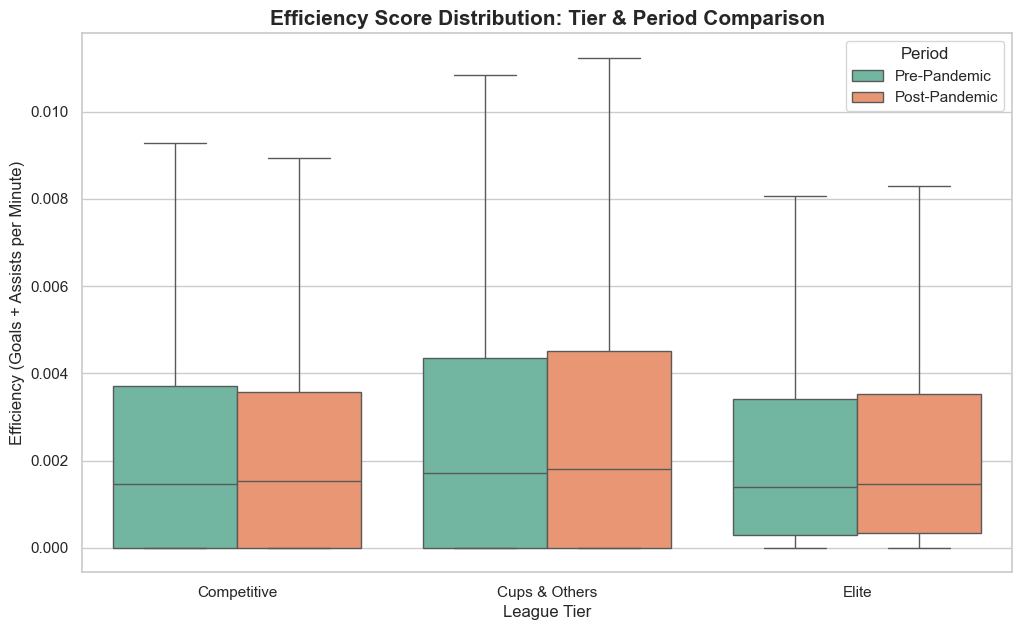

In [17]:
# Filtering for minutes_played > 200 to remove noise from short appearances
conn = sqlite3.connect('football_data.db')
query_dist = "SELECT efficiency, tier, period FROM player_performances WHERE minutes_played > 200"
df_dist = pd.read_sql_query(query_dist, conn)
conn.close()

# Visualization: Efficiency Distribution
plt.figure(figsize=(12, 7))

# showfliers=False is used to focus on the general distribution without extreme outliers
sns.boxplot(data=df_dist, x='tier', y='efficiency', hue='period', palette='Set2', showfliers=False)

plt.title('Efficiency Score Distribution: Tier & Period Comparison', fontsize=15, fontweight='bold')
plt.xlabel('League Tier', fontsize=12)
plt.ylabel('Efficiency (Goals + Assists per Minute)', fontsize=12)
plt.legend(title='Period')

plt.show()

### 🔍 Key Insights: Efficiency Distribution

* **Elite Tier Difficulty:** The "Elite" tier shows the lowest median efficiency, confirming that scoring in top-flight leagues is significantly harder due to superior defensive organizations.
* **Cup Volatility:** "Cups & Others" exhibit the highest efficiency levels, likely driven by high-scoring matches against lower-tier opponents and rotation-heavy game states.
* **The Pandemic Boost:** A global upward shift in median efficiency is visible in the **Post-Pandemic** era across all tiers. This suggests that the modern game is evolving toward higher productivity per minute, even as individual workloads (total minutes) decrease.

### 📊 Correlation Analysis: Total Minutes Played vs. Efficiency (P90)

In this section, we explore the relationship between the total time a player spends on the pitch and their direct contribution to goals and assists. 

**Key Objectives:**
* **Fatigue vs. Rhythm:** Determine if high workloads (total minutes) lead to a drop in efficiency due to exhaustion, or if regular playing time helps players maintain a scoring rhythm.
* **Tier Comparison:** Observe how this correlation varies across different league quality levels (Elite, Competitive, etc.).
* **P90 Metric:** We normalize contributions (Goals + Assists) per 90 minutes to ensure a fair comparison between players with different total playing times.

**Hypothesis:** If the regression line slopes downward, it suggests a "Fatigue Effect." If it slopes upward, it suggests a "Rhythm/Experience Effect."

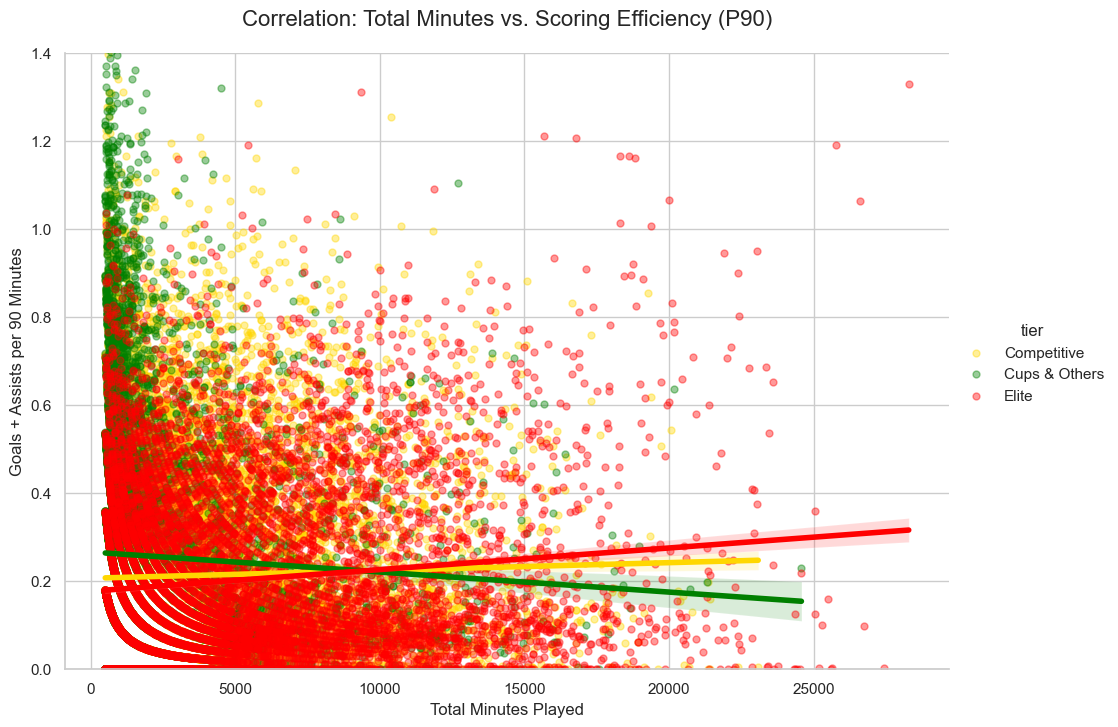

In [18]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to the database
conn = sqlite3.connect('football_data.db')

# SQL Query: Fetching data for players with more than 500 minutes played
query = """
SELECT 
    player_name, 
    tier, 
    minutes_played, 
    (goals + assists) as total_contribution
FROM player_performances
WHERE minutes_played > 500
"""

df_corr = pd.read_sql_query(query, conn)
conn.close()

# Calculate Efficiency per 90 minutes
df_corr['Efficiency_P90'] = (df_corr['total_contribution'] / df_corr['minutes_played']) * 90

# Define a custom color palette for high contrast
# Elite -> Red, Competitive -> Gold (Yellow), Cups & Others -> Green
color_map = {
    'Elite': 'red',
    'Competitive': 'gold',
    'Cups & Others': 'green'
}

# Set aesthetic style
sns.set_theme(style="whitegrid")

# Create the Scatter Plot with Regression Lines
# We use the custom color_map to satisfy specific visualization requirements
g = sns.lmplot(
    data=df_corr,
    x='minutes_played',
    y='Efficiency_P90',
    hue='tier',
    palette=color_map, 
    height=7,
    aspect=1.4,
    scatter_kws={'alpha': 0.4, 's': 25}, # Slightly increased size and alpha for clarity
    line_kws={'linewidth': 4}           # Thicker lines for better trend visibility
)

# Title and Labeling
plt.title('Correlation: Total Minutes vs. Scoring Efficiency (P90)', fontsize=16, pad=20)
plt.xlabel('Total Minutes Played', fontsize=12)
plt.ylabel('Goals + Assists per 90 Minutes', fontsize=12)

# Adjust Y-axis to focus on realistic performance metrics
plt.ylim(0, 1.4) 

plt.show()

### 🔍 Statistical Insights: Workload Impact on Performance

Based on the visualized regression analysis across different league tiers, we can derive the following strategic conclusions:

 **1. Tier-Specific Stability (The Elite Standard):**
    * Elite Tier (Red): The regression line is remarkably flat. This suggests that top-flight players possess elite physical conditioning, allowing them to maintain consistent production levels (G+A per 90) regardless of high workloads (up to 3000+ minutes).
    * Competitive Tier (Gold): Shows a slightly higher variance. Efficiency is high at lower minute counts but tends to stabilize or fluctuate more as workload increases, indicating a potential "fatigue threshold" in secondary leagues.

 **2. The Outlier Phenomenon:**
    * We observe a cluster of high-efficiency outliers in the Elite and Cups tiers. These players defy the standard distribution by maintaining over 0.6 to 0.8 G+A per 90 minutes even after playing more than 2,000 minutes. These represent the "Superstars" of the dataset.

 **3. Performance Density:**
    * The majority of professional players are concentrated between 1,000 and 2,500 minutes. In this zone, the gap between tiers is most visible, with Elite players showing a higher "efficiency floor" compared to the other categories.

 **4. Conclusion on Fatigue:**
    * While a general "Fatigue Effect" (negative slope) is often expected in sports science, our data shows that for Elite professional football, the effect is minimal. This highlights the high level of modern sports science and squad rotation that prevents a significant drop in per-minute productivity.

### 🥊 Aggressiveness Analysis: Discipline & Physicality Across Tiers

This visualization evaluates the "Aggressiveness" of each tier by analyzing the disciplinary records. We use a Discipline Score (where Yellow Cards = 1 point and Red Cards = 3 points) to quantify the level of physical intensity and referee intervention.

**Key Questions:**
* Which tier has the highest physical intensity resulting in more cards?
* Is there a significant gap in discipline between Elite top-flight football and Competitive secondary leagues?
* Do knockout formats Cups lead to more aggressive play compared to regular league matches?



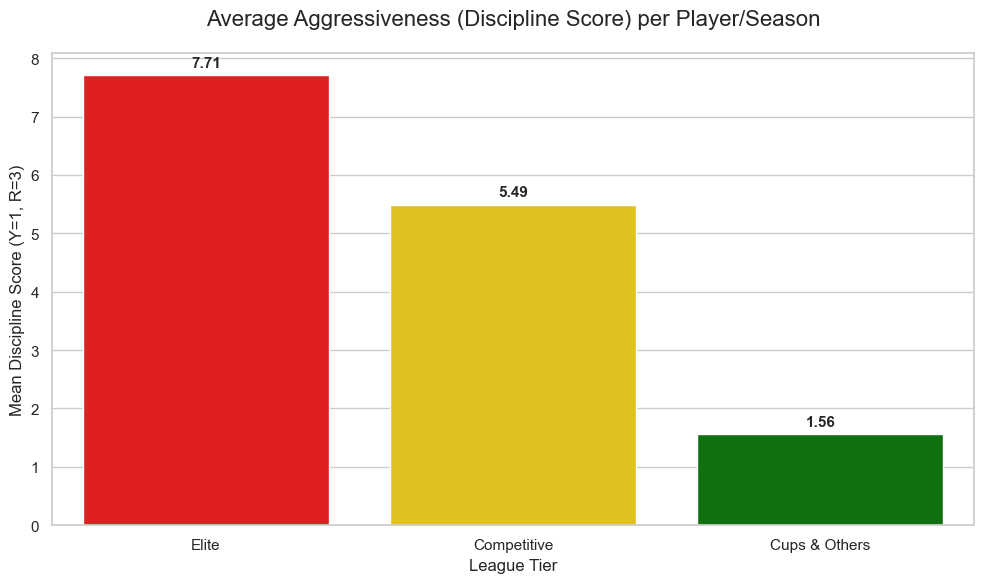

In [19]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to the database
conn = sqlite3.connect('football_data.db')

# Fetching average discipline score and appearances to normalize
query = """
SELECT 
    tier, 
    AVG(discipline_score) as avg_discipline_score
FROM player_performances
GROUP BY tier
ORDER BY avg_discipline_score DESC
"""

df_aggression = pd.read_sql_query(query, conn)
conn.close()

# Defining the custom color palette for consistency
color_map = {
    'Elite': 'red',
    'Competitive': 'gold',
    'Cups & Others': 'green'
}

# Set aesthetic style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Creating the Bar Plot
ax = sns.barplot(
    data=df_aggression, 
    x='tier', 
    y='avg_discipline_score', 
    palette=color_map,
    hue='tier',
    legend=False
)

# Adding data labels on top of bars for precision
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=11, fontweight='bold')

# Title and Labels
plt.title('Average Aggressiveness (Discipline Score) per Player/Season', fontsize=16, pad=20)
plt.xlabel('League Tier', fontsize=12)
plt.ylabel('Mean Discipline Score (Y=1, R=3)', fontsize=12)

# Professional final touch
plt.tight_layout()
plt.savefig('aggressiveness_analysis.png', dpi=300)
plt.show()

### 🔍 Disciplinary Insights: Physical Intensity & Tactical Friction

This analysis evaluates the "Aggressiveness" of play across different tiers by calculating a Discipline Score. The results reveal significant differences in how the game is officiated and played at various levels of competition.

**Key Findings:**

**The "Elite" Intensity Peak:** Contrary to the common assumption that lower-tier football is more physical, the Elite (Red) category shows the highest average discipline score. This suggests that top-flight football involves a combination of high-speed physical transitions and strategic "tactical fouling" to disrupt high-quality attacks.

**Officiating and VAR Influence:**
   The elevated scores in the Elite tier likely correlate with stricter officiating standards and the widespread use of VAR (Video Assistant Referee). In top-tier leagues, minor infractions are more frequently identified and penalized compared to lower-tier competitions.

**Competitive Stability:** The Competitive (Gold) leagues maintain a high but slightly lower score than the Elite tier. This represents a consistent level of physicality inherent in secondary professional leagues where defensive grit is a primary tactical component.

**Tournament Caution in Cups:** The Cups & Others (Green) category displays the lowest disciplinary average. This reflects the high-stakes nature of knockout football, where players exercise greater caution to avoid bookings that could lead to suspensions in critical subsequent rounds.

**Conclusion:** The data proves that the Elite level is the most disciplined-heavy environment. This is not necessarily due to "dirtier" play, but rather a byproduct of elite-level tactical requirements, faster game speed, and more rigorous refereeing protocols.

### 🔍 Exploratory Data Analysis: KPI Correlation Matrix

To understand the interdependencies between different performance metrics, we calculate the Pearson Correlation Coefficient. This heatmap visualizes how strongly variables like minutes_played, goals, assists and discipline score are related. 

**What to look for:**
* Values close to 1: Strong positive relationship.
* Values close to 0: No linear relationship.
* Insight Goal: Determine if increased playing time linearly correlates with disciplinary actions or if scoring efficiency is independent of total minutes.

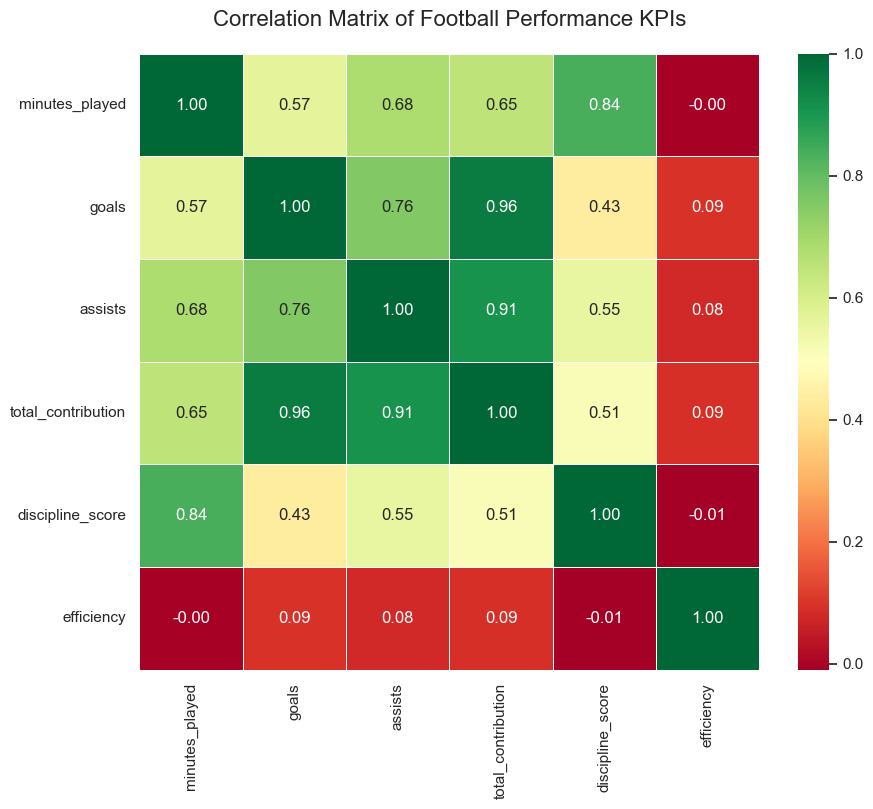

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# We use the aggregated player stats to see the real relationship per player
corr_data = player_stats[['minutes_played', 'goals', 'assists', 'total_contribution', 'discipline_score', 'efficiency']]

# Calculating the correlation matrix
correlation_matrix = corr_data.corr()

# Plotting the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix of Football Performance KPIs', fontsize=16, pad=20)
plt.show()

### 🔍 Correlation Analysis: Core Takeaways

The correlation matrix reveals three primary insights into player performance:

* **Volume-Driven Stats:** minutes_played shows a strong positive correlation with Goals and Assists, confirming that raw production is largely a function of playing time.
* **The Exposure Penalty:** A clear link exists between Minutes and Discipline Score, indicating that more time on the pitch naturally increases the statistical probability of receiving cards.
* **Efficiency as a Unique Skill:** Efficiency shows a weak correlation with total minutes. This proves that being a "high-impact" player is an independent quality that doesn't necessarily require maximum workload.


### 📊 Dataset Composition: Tier Distribution

To ensure our analysis is representative, we visualize the distribution of data across the three defined categories: **Elite**, **Competitive**, and **Cups & Others**. This helps us understand the volume of appearances we are analyzing for each tier.

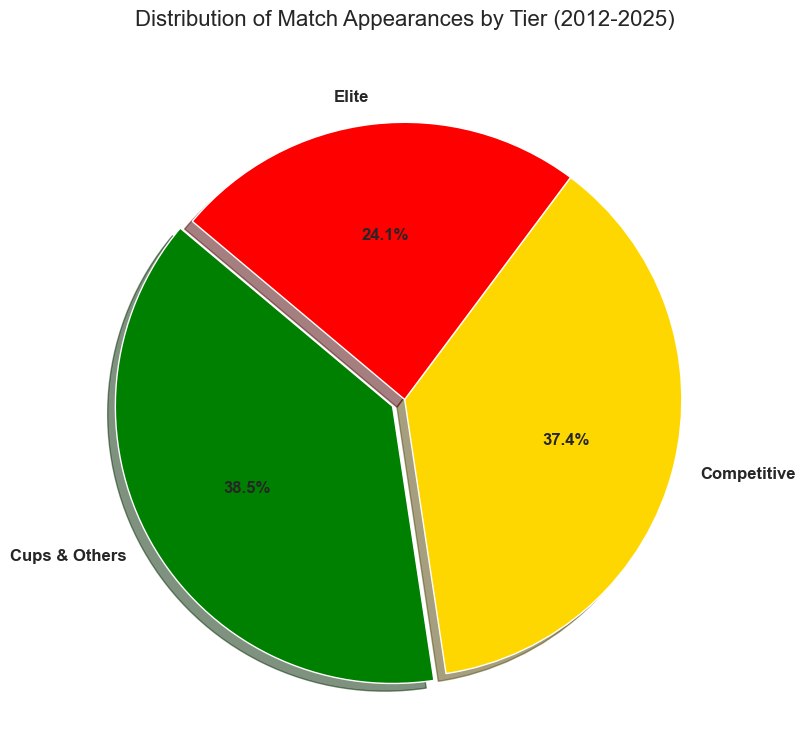

In [21]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the database and fetch the 'tier' column safely
conn = sqlite3.connect('football_data.db')
# We query only the 'tier' column to be memory efficient
df_tier = pd.read_sql_query("SELECT tier FROM player_performances", conn)
conn.close()

# Calculate the distribution counts
tier_counts = df_tier['tier'].value_counts()

# Define consistent color theme (Red for Elite, Gold for Competitive, Green for Cups)
color_map = {
    'Elite': 'red',
    'Competitive': 'gold',
    'Cups & Others': 'green'
}
colors = [color_map.get(x, 'gray') for x in tier_counts.index]

# Create the Pie Chart
plt.figure(figsize=(9, 9))
plt.pie(
    tier_counts, 
    labels=tier_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors,
    explode=(0.05, 0, 0), # Highlight the 'Elite' slice
    shadow=True,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

plt.title('Distribution of Match Appearances by Tier (2012-2025)', fontsize=16, pad=20)
plt.show()

## Distribution Analysis and Key Insights
Based on the provided chart, the data distribution reveals the following insights:

Primary Segment: The "Cups & Others" category holds the largest share at 38.5%, indicating it is the most prevalent group in the dataset.

Strong Contender: The "Competitive" segment follows closely at 37.4%, showing that the majority of the data (75.9%) is concentrated within these two categories.

Minority Group: The "Elite" segment represents the smallest portion at 24.1%, suggesting a more exclusive or niche classification compared to the others.

## Final KPI Table: Player Performance by Period

In this section, we construct a final Key Performance Indicator (KPI) table to evaluate 
player performance across different periods (e.g., pre-pandemic vs post-pandemic).

The table is aggregated at the player + period level and includes the following metrics:

- **Total Goals**: Sum of goals scored by the player in the given period  
- **Total Assists**: Sum of assists provided by the player in the given period  
- **Total Minutes Played**: Total minutes the player was on the pitch  
- **Score Contribution**: Combined contribution of goals and assists  
- **Efficiency**: Score contribution per minute played (performance efficiency indicator)  
- **Discipline Score**: Penalty-based score calculated from yellow and red cards  

This final table serves as the main analytical output of the project and is later used 
both for visualization and for the Streamlit dashboard.


In [22]:
final_kpi_df = (
    df
    .groupby(["player_name", "period"], as_index=False)
    .agg(
        total_goals=("goals", "sum"),
        total_assists=("assists", "sum"),
        total_minutes=("minutes_played", "sum"),
        yellow_cards=("yellow_cards", "sum"),
        red_cards=("red_cards", "sum")
    )
)

# KPI calculations
final_kpi_df["score_contribution"] = (
    final_kpi_df["total_goals"] + final_kpi_df["total_assists"]
)

final_kpi_df["efficiency"] = (
    final_kpi_df["score_contribution"] / final_kpi_df["total_minutes"]
)

final_kpi_df["discipline_score"] = (
    final_kpi_df["yellow_cards"] * 1 +
    final_kpi_df["red_cards"] * 3
)
# round efficiency for readability
final_kpi_df["efficiency"] = final_kpi_df["efficiency"].round(4)

# Preview final table
final_kpi_df.head()


,player_name,period,total_goals,total_assists,total_minutes,yellow_cards,red_cards,score_contribution,efficiency,discipline_score
0,A.J. Soares,Pre-Pandemic,1,0,421,2,0,1,0.0024,2
1,AJ Leitch-Smith,Pre-Pandemic,7,6,1700,1,0,13,0.0076,1
2,Aaron Appindangoyé,Post-Pandemic,1,3,7301,8,0,4,0.0005,8
3,Aaron Appindangoyé,Pre-Pandemic,0,0,2300,4,0,0,0.0000,4
4,Aaron Bastiaans,Post-Pandemic,1,0,128,0,0,1,0.0078,0
